# Swing Mode - Infinite Bus

|  | Mode | Description |
| --- | --- | --- |
| 1 | __"Swing"__ | __Ideal voltage source without dynamics (i.e., an infinite bus)__ |
| 2 | "PQ" | Grid following controllable source/load (real and imaginary power) |
| 3 | "Droop" | Simple grid forming with power balancing through a droop mechanism |
| 4 | "Synchronverter" or "VSG"|  Grid forming control mimicking a generator, i.e., virtual synchronous generator |

- There are a number of in-built "classically" control modes, which can be applied to the energy sources. 
- All sources of energy are modelled as voltage supplies, which are effective models (or averaged models) of power electronic converters.

## Summary

- This notebook is intended to introduce you to the simplest control mode available, i.e., "open-loop" control. 
- One source, an ideal oscillating voltage source, which is generating a 3-phase AC signal while connected to a static load through a cable.
- Plotting of the simulation results.


![](figures/Swing_mode.jpg)

In [1]:
using ElectricGrid;

_______________________________________________________________________________
### Network Configuration 

- We specify the control mode of the source as "Swing", often referred to as an infinite bus. 
- This is open-loop control of the source, where the output voltage magnitude, relative angle, and frequency at the source terminals are fixed.

In [2]:
# total run time, seconds
t_end = 0.1     

# Connectivity Matrix
CM = [ 0. 1.
        -1. 0.]     

parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr"       => 100e3,    # Power Rating [VAr]
                                        "mode"     => "Swing",  # Controller mode
                                        "v_pu_set" => 1.05,     # Voltage set point [per unit]
                                        "v_δ_set"  => 20.0),    # Angle set point [degrees]
                        ],
        "load"   => Any[
                        Dict{Any, Any}("impedance" => "RL", 
                                        "R"        => 3.73, 
                                        "L"        => 0.019),
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R"         => 0.1, 
                                        "L"        => 0.25e-3, 
                                        "C"        => 0.1e-4),
                        ],
        "grid"   => Dict{Any, Any}("f_grid"        => 60.0,     # Nominal grid frequency [Hz]
                                    "ramp_end"     => 0.04,     # Ramp up time to voltage set point [s]
                                    "v_rms"        => 230)      # Nominal grid voltage line-to-neutral [V]
    );

_______________________________________________________________________________
###  Defining the environment

To put all of the parameters together and construct the Linear Time Invariant (LTI) system of equations we run the following command.

In [4]:
env = ElectricGridEnv(CM = CM, parameters = parameters, t_end = t_end, verbosity = 2);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ JEG c:\Gitlab\JEG\ElectricGrid.jl\src\electric_grid_env.jl:329
┌ Info: Time simulation run time: 0.1 [s] ~> 1001 steps
└ @ JEG c:\Gitlab\JEG\ElectricGrid.jl\src\electric_grid_env.jl:330


_______________________________________________________________________________
### Initialising the Controller 

- All sources are controlled within the reinforcement learning framework, even if the control mode selected for the source does not entail any "learning" or "training" of the control structure. 
- If not specified by the user, for all the classically controlled "agents", the function SetupAgents computes all the necessary coefficients for control.

In [5]:
agent = SetupAgents(env);

┌ Info: 1 'classically' controlled source has been initialised.
└ @ JEG c:\Gitlab\JEG\ElectricGrid.jl\src\classical_control.jl:2684
┌ Info: 1 source has been set up in Swing mode.
└ @ JEG c:\Gitlab\JEG\ElectricGrid.jl\src\classical_control.jl:2695
┌ Info: All 'classically' controlled sources have been automatically set up with droop coeficients, and proportional and integral gains.
└ @ JEG c:\Gitlab\JEG\ElectricGrid.jl\src\classical_control.jl:2707


_______________________________________________________________________________
### Running the Time Domain Simulation 

- The system is evolved for the specified amount of time, controller actions are computed, and the results are stored in a "hook". 
- Most relevant quantities are automatically collected, however, by passing a DataHook to the "simulate" function, signals may be specified.

In [6]:
hook = Simulate(agent, env);

_______________________________________________________________________________
### Low-Level Rendering

- The software solves the electrical network in the time domain using a set of linear time-invariant ODEs.
- For illustration reasons, the source voltage (action) and current through the filter inductor (state) of phase 'a' are shown below.

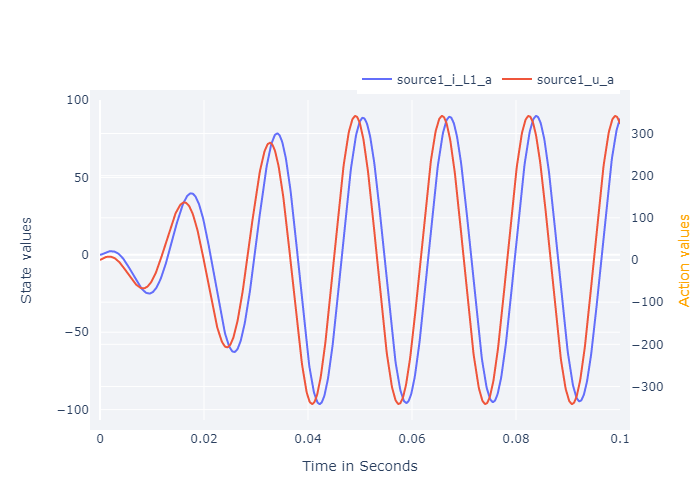

In [7]:
RenderHookResults(hook = hook, 
                    states_to_plot  = ["source1_i_L1_a"], # Inductor current [A]
                    actions_to_plot = ["source1_u_a"],    # Inverter voltage [V]
                    )

_______________________________________________________________________________
### High-Level Rendering

- When sources are classically controlled and the network is a 3 phase system, the user has the option of plotting a number of additional quantities. 
- The only quantities that can be plotted for reinforcement learning controllers are those specified through "states_to_plot" and "actions_to_plot".
- The elements of the vectors in the function "RenderHookResults" refer to the _name_ of the classically controlled source which may differ if there are RL sources in the network, e.g., power_p_inv = [1], indicates that the real power of the first _classically_ controlled source should be plotted.


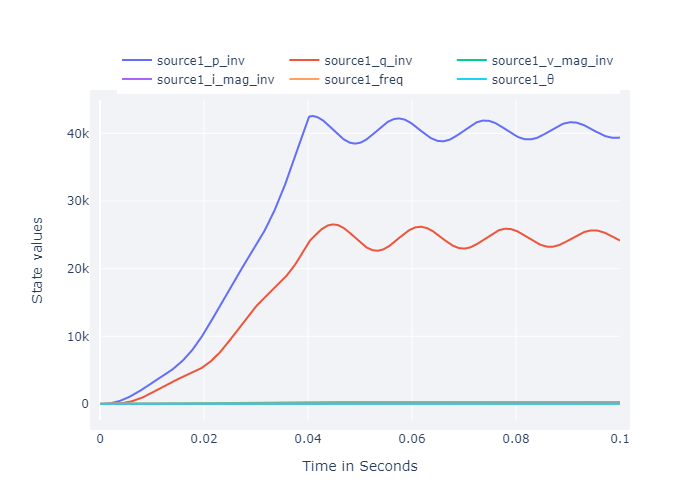

In [8]:
RenderHookResults(hook = hook, 
                    states_to_plot  = [], 
                    actions_to_plot = [],  
                    power_p_inv     = [1], # Real power [Watts]
                    power_q_inv     = [1], # Imaginary power [VAi]
                    v_mag_inv       = [1], # Scaled L₂ norm in αβγ coordinates [V]
                    i_mag_inv       = [1], # Scaled L₂ norm in αβγ coordinates [A]
                    angles          = [1], # Relative angle [degrees]
                    freq            = [1], # Angular velocity [Hz]
                    )

_______________________________________________________________________________
### Analysis

- The plot shows the instantaneous 3-phase real [W] and imaginary [VAi] power delivered by the source. 
- The frequency is a constant 60 Hz.
- The relative positive phase sequence angle at the terminals of the source is 20 degrees.
- The voltage at the source terminals ramps up to a magnitude of 1.05*230 V over a period of 0.04 s.